# Submitted By: M. Raza Khalid Saleemi
# 1. Introduction

CNN model for Bee **subspecies**


In [1]:
#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import seaborn as sns


# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from sklearn.preprocessing import OneHotEncoder
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import tensorflow

#####################################
# Settings
#####################################

# Set random seed to make results reproducable
np.random.seed(42)
tensorflow.random.set_seed(42)

# Global variables
img_folder= '../input/honeybeeannotatedimages/bee_imgs/bee_imgs/'
img_width= 70
img_height= 70
img_channels= 3
Batch_size= 32
no_of_epochs= 100

Using TensorFlow backend.


# 2. Read Bee data

In [2]:
bees=pd.read_csv('../input/honeybeeannotatedimages/bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})
#bees = bees.sample(300)

# Will use this function later to load images of preprocessed bees
# Don't load images just from the start to save memory for preprocessing steps
def read_img(file):
    """
    Read and resize img, adjust channels. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    @param file: file name without full path
    """
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

# Cannot impute nans, drop them
bees.dropna(inplace=True)

# Some image files don't exist. Leave only bees with available images.
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
bees = bees[img_exists]

bees.head()


,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


# 3. Bee subspecies classification
Preprocessing includes data balancing and augmentation.
Then we'll be ready to train CNN.

## 3.1. Data preprocessing for Bee subspecies
### 3.1.1 Balancing samples by subspecies
Split all Bees to train, validation and test. Then balance train dataset.
Splitting should be done before balancing to avoid putting the same upsampled Bee to both train and test.


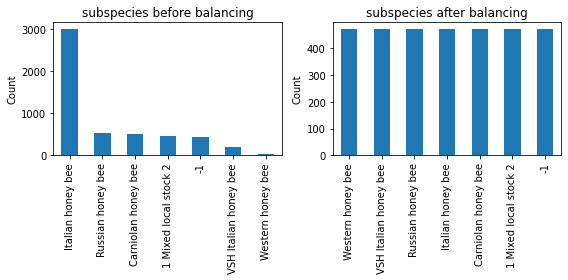

In [3]:
# The same split-balance idea will be used in 2 places: subspecies and health CNN.
# Let's put this logic in function here to reuse.
def split_balance(bees, field_name):
    """ 
    Split to train, test and validation. 
    Then balance train by given field name.
    Draw plots before and after balancing
    
    @param bees: Total Bees dataset to balance and split
    @param field_name: Field to balance by
    @return:  balanced train bees, validation bees, test bees
    """
    # Split to train and test before balancing
    train_bees, test_bees = train_test_split(bees, test_size=0.2, random_state=42)

    # Split train to train and validation datasets
    # Validation for use during learning
    train_bees, val_bees = train_test_split(train_bees, test_size=0.2, random_state=42)

    #Balance by subspecies to train_bees_bal_ss dataset
    # Number of samples in each category
    ncat_bal = int(len(train_bees)/train_bees[field_name].cat.categories.size)
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_bees_bal, val_bees, test_bees)
    
def plot_balanced(train_bees, train_bees_bal, field_name):
    """
    Draw distribution of field by categories before and after balancing
    @param train_bees: before balancing
    @param train_bees_bal: after balancing
    @param field_name: balancing field
    """
    # Plot before and after balancing
    f, axs = plt.subplots(1,2, figsize=(8,4))

    # Before
    ax = train_bees[field_name].value_counts().plot(kind='bar', ax=axs[0])
    ax.set_title('%s before balancing' % field_name)
    ax.set_ylabel('Count')

    # After
    ax = train_bees_bal[field_name].value_counts().plot(kind='bar', ax=axs[1])
    ax.set_title('%s after balancing' % field_name)
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(bees, 'subspecies')
plot_balanced(bees, train_bees_bal, 'subspecies')

# Will use balanced dataset as main
train_bees = train_bees_bal

****
### 3.1.2 Prepare features
We prepared train_bees dataset but did not load images from files until this state. Now load them and use ImageDataGenerator to randomly shift/rotate/zoom. 

In [4]:
# The same way of loading images and one hot encoding will be used in 2 places: subspecies and health CNN.
# Let's put this logic in function here to reuse.
def prepare2train(train_bees, val_bees, test_bees, field_name):
    """
    Load images for features, drop other columns
    One hot encode for label, drop other columns
    @return: image generator, train images, validation images, test images, train labels, validation labels, test labels
    """
    # Bees already splitted to train, validation and test
    # Load and transform images to have equal width/height/channels. 
    # read_img function is defined in the beginning to use in both health and subspecies. 
    # Use np.stack to get NumPy array for CNN input

    # Train data
    train_X = np.stack(train_bees['file'].apply(read_img))
    #train_y = to_categorical(train_bees[field_name].values)
    train_y  = pd.get_dummies(train_bees[field_name], drop_first=False)

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val_bees['file'].apply(read_img))
    #val_y = to_categorical(val_bees[field_name].values)
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(read_img))
    #test_y = to_categorical(test_bees[field_name].values)
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

#train_bees['subspecies'].cat.values[:-100]
# Call image preparation and one hot encoding
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'subspecies')

In [5]:
train_X.shape

(3304, 70, 70, 3)

In [6]:
Training_Samples = len(train_X)

In [7]:
steps_per_epoch = Training_Samples // Batch_size


## 3.2 Train Bee Subspecies CNN

In [8]:
annealer1 = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+no_of_epochs))

# We'll stop training if no improvement after some epochs
#earlystopper1 = EarlyStopping(monitor='loss', patience=1, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
# Build CNN model
model1=Sequential()
model1.add(Conv2D(16, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization(axis=-1))
#model1.add(Dropout(0.1))
model1.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization(axis=-1))
model1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization(axis=-1))
model1.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization(axis=-1))
model1.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization(axis=-1))
model1.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(BatchNormalization(axis=-1))
model1.add(Conv2D(1024, kernel_size=3, activation='relu', padding='same'))
model1.add(BatchNormalization())
#model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(train_y.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 17, 17, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)       

In [9]:
# Train
training1 = model1.fit_generator(generator.flow(train_X,train_y, batch_size= Batch_size)
                        ,epochs= no_of_epochs
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch= steps_per_epoch
                        ,callbacks=[ checkpointer1, annealer1 ])
# Get the best saved weights
model1.load_weights('best_model1.h5')

Epoch 1/100
103/103 [==============================] - 12s 112ms/step - loss: 0.6792 - accuracy: 0.8075 - val_loss: 4.3322 - val_accuracy: 0.0990

Epoch 00001: val_accuracy improved from -inf to 0.09903, saving model to best_model1.h5
Epoch 2/100
103/103 [==============================] - 6s 54ms/step - loss: 0.3789 - accuracy: 0.8744 - val_loss: 4.7731 - val_accuracy: 0.1002

Epoch 00002: val_accuracy improved from 0.09903 to 0.10024, saving model to best_model1.h5
Epoch 3/100
103/103 [==============================] - 6s 59ms/step - loss: 0.3192 - accuracy: 0.8878 - val_loss: 5.5613 - val_accuracy: 0.1135

Epoch 00003: val_accuracy improved from 0.10024 to 0.11353, saving model to best_model1.h5
Epoch 4/100
103/103 [==============================] - 6s 60ms/step - loss: 0.2955 - accuracy: 0.9010 - val_loss: 1.2105 - val_accuracy: 0.6908

Epoch 00004: val_accuracy improved from 0.11353 to 0.69082, saving model to best_model1.h5
Epoch 5/100
103/103 [==============================] - 5s

103/103 [==============================] - 6s 56ms/step - loss: 0.0735 - accuracy: 0.9765 - val_loss: 0.2988 - val_accuracy: 0.8732

Epoch 00080: val_accuracy did not improve from 0.92633
Epoch 81/100
103/103 [==============================] - 6s 55ms/step - loss: 0.0738 - accuracy: 0.9752 - val_loss: 0.2387 - val_accuracy: 0.9130

Epoch 00081: val_accuracy did not improve from 0.92633
Epoch 82/100
103/103 [==============================] - 5s 52ms/step - loss: 0.0890 - accuracy: 0.9710 - val_loss: 0.3184 - val_accuracy: 0.9082

Epoch 00082: val_accuracy did not improve from 0.92633
Epoch 83/100
103/103 [==============================] - 5s 52ms/step - loss: 0.0724 - accuracy: 0.9728 - val_loss: 0.2088 - val_accuracy: 0.9191

Epoch 00083: val_accuracy did not improve from 0.92633
Epoch 84/100
103/103 [==============================] - 5s 52ms/step - loss: 0.0706 - accuracy: 0.9743 - val_loss: 0.1936 - val_accuracy: 0.9275

Epoch 00084: val_accuracy improved from 0.92633 to 0.92754, sav

## 3.3 Evaluate bee subspecies detection model

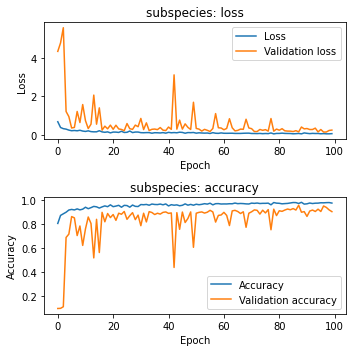

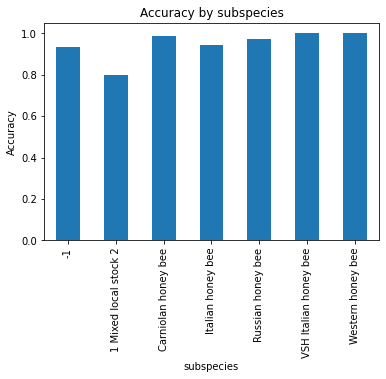

Classification report
                       precision    recall  f1-score   support

                   -1       0.88      0.93      0.91        88
1 Mixed local stock 2       0.73      0.81      0.77        84
  Carniolan honey bee       0.99      0.99      0.99        91
    Italian honey bee       0.97      0.95      0.96       604
    Russian honey bee       1.00      0.97      0.99       114
VSH Italian honey bee       0.94      1.00      0.97        49
    Western honey bee       0.83      1.00      0.91         5

             accuracy                           0.94      1035
            macro avg       0.91      0.95      0.93      1035
         weighted avg       0.95      0.94      0.94      1035

Loss function: 0.21848974648305183, accuracy: 0.9429951906204224


In [14]:
# This is a function to use in Bee subspecies and health evaluation
def eval_model(training, model, test_X, test_y, field_name):
    """
    Model evaluation: plots, classification report
    @param training: model training history
    @param model: trained model
    @param test_X: features 
    @param test_y: labels
    @param field_name: label name to display on plots
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training1.history['accuracy'], label="Accuracy")
    ax[1].plot(training1.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)
    
    acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum()/test_y.sum()
    acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    plt.ylabel('Accuracy')
    plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y.values, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=test_y.columns))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

# Call evaluation function
eval_model(training1, model1, test_X, test_y, 'subspecies')

In [15]:
test=pd.read_csv('../input/ds-14/test.csv',
                index_col=False,  
                dtype={'health':'category','location':'category'})
test.head()

,file,date,location,health
0,040_270.png,8/21/18,"Athens, GA, USA","few varrao, hive beetles"
1,016_004.png,8/20/18,"San Jose, CA, USA",healthy
2,005_112.png,7/7/18,"Saratoga, CA, USA",healthy
3,015_466.png,8/6/18,"Saratoga, CA, USA",healthy
4,015_777.png,8/6/18,"Saratoga, CA, USA",healthy


In [16]:
test['img'] = test['file'].apply(read_img)
test.dropna(inplace=True)

# Print sample data without img array
test.drop('img',axis=1).head()

,file,date,location,health
0,040_270.png,8/21/18,"Athens, GA, USA","few varrao, hive beetles"
1,016_004.png,8/20/18,"San Jose, CA, USA",healthy
2,005_112.png,7/7/18,"Saratoga, CA, USA",healthy
3,015_466.png,8/6/18,"Saratoga, CA, USA",healthy
4,015_777.png,8/6/18,"Saratoga, CA, USA",healthy


In [17]:
test_X = np.stack(test.img)
#train_y = to_categorical(train_bees[field_name].values)

testing = pd.read_csv('../input/honeybeeannotatedimages/bee_data.csv',
                index_col=False,  
                dtype={'subspecies':'category', 'health':'category','location':'category'})
testing['img'] = test['file'].apply(read_img)
testing.dropna(inplace=True)

test_y  = pd.get_dummies(testing['subspecies'], drop_first=False)

print(test_X.shape)
print(test_y.shape)

(1000, 70, 70, 3)
(1000, 7)


In [18]:
test_pred = model1.predict(test_X)
test_pred.shape

(1000, 7)

In [19]:
test_pred[0:10]

array([[4.66737265e-06, 3.54770750e-01, 9.52753396e-08, 6.45216167e-01,
        7.55798965e-06, 7.47278989e-07, 8.55364775e-08],
       [9.99573767e-01, 1.33181122e-04, 7.87109570e-07, 1.64594341e-04,
        1.47908196e-07, 7.39119287e-07, 1.26769650e-04],
       [5.80049971e-07, 3.10238055e-03, 1.48880872e-08, 9.96896505e-01,
        2.16871442e-07, 2.27459296e-07, 2.31548802e-09],
       [3.62037477e-04, 2.73319427e-04, 6.33897514e-07, 9.99360263e-01,
        3.77304923e-06, 9.23598336e-08, 5.06097564e-09],
       [3.14724735e-09, 4.90651701e-06, 1.04062224e-07, 9.99994993e-01,
        5.12941956e-09, 3.58249151e-12, 1.76748400e-13],
       [3.21136904e-03, 1.98262715e-05, 5.39504130e-09, 9.96765614e-01,
        7.95348058e-07, 2.46221362e-06, 8.93902108e-09],
       [1.60505242e-05, 7.50650997e-06, 1.74107484e-09, 9.99976158e-01,
        2.11559779e-07, 5.01001240e-10, 3.35527647e-11],
       [2.90629517e-11, 1.39698495e-05, 1.10311923e-03, 1.86622401e-06,
        9.98880804e-01, 4

In [20]:
test_pred = np.argmax(test_pred, axis=1)
test_pred[0:10]

array([3, 0, 3, 3, 3, 3, 3, 4, 0, 3])

In [22]:
def findit(x,test_y):
    return test_y.columns[x]
names = []
for x in test_pred:
    names.append(findit(x,test_y))

print(names)

['Italian honey bee', '-1', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Russian honey bee', '-1', 'Italian honey bee', 'Italian honey bee', 'VSH Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Russian honey bee', '-1', '1 Mixed local stock 2', 'Carniolan honey bee', 'Italian honey bee', 'Italian honey bee', 'VSH Italian honey bee', '1 Mixed local stock 2', 'Western honey bee', '-1', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Russian honey bee', 'Russian honey bee', 'Italian honey bee', 'Italian honey bee', 'Russian honey bee', 'Russian honey bee', '1 Mixed local stock 2', 'Italian honey bee', 'Italian honey bee', '1 Mixed local stock 2', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', 'Italian honey bee', '1 Mixed local stock 2', 'Italian honey bee', 'Italian honey bee', 

In [23]:
test.file.shape

(1000,)

In [24]:
submission=pd.DataFrame({'file':test.file,'subspecies':names})

In [25]:
submission.set_index(submission.columns[0],inplace= True)

In [26]:
# Write code here
submission.to_csv('Submission_CNN_ver_X.csv')